# <font  color = "#0093AF"> Cross-Effect

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_CrossEffect.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The cross-effect$^{1,2}$ is a particularly popular approach to DNP enhancement, where two coupled electrons with resonance frequencies separated by the nuclear Larmor frequency undergo a three-spin flip with the electron.

$$
\begin{equation}
\pm\omega_n=\omega_{e1}-\omega_{e2}
\end{equation}
$$

Enhancement on the nucleus is induced if the polarization of the two electrons is different. This is achieved by applying a saturating field to the electrons, such that one becomes more saturated than the other.

Most orientations of electron pairs in the sample do not match the above condition, however, magic angle spinning will bring most crystallites through the cross-effect matching condition at some point in the rotor period,$^3$ allowing it to nonetheless be an effective mechanism of enhancement. However, MAS will also cause both electrons to get saturated at various points during the rotor period, and also electron-electron transfer without the nucleus becomes possible if the two electrons have the same resonance frequency at some point during the rotor period. 

We investigate the various complications of cross effect here, along with the role of electron relaxation for this transfer.

[1] A.V. Kessenikh, V.L. Luschikov, A.A. Manenkov, Y. Taran. *Sov. Phys. Solid State*, **1963**, 6, 321-329

[2] C.F. Hwang, D.A. Hill. *[Phys. Rev. Lett.](https://doi.org/10.1103/PhysRevLett.19.1011)*, **1967**, 19, 1011-1014.

[3] K.R. Thurber, R. Tycko. *[J. Chem. Phys.](https://doi.org/10.1063/1.4747449)*, **2012**, 137, 084508.

## Setup

In [0]:
# SETUP SLEEPY

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
from time import time

## $^1$H Magnetization without and with e- irradiation

### Calculate a spectrum of one electron under MAS

We would like to know roughly where to irradiate for effective cross effect. We can capture a large portion of the spectrum from a single crystal orientation, because the offset of the electron from its center frequency is much larger than the rotor frequency. However, when a given frequency is sampled, the magnetization is not usually starting on x, so that the signal cannot be phased. Note that we increase the MAS frequency to get a broader spectral width with fewer steps in the rotor period.

In [14]:
# Center electron g-tensor on ge
gxx,gyy,gzz=2.0022,2.0059,2.0098
gxx,gyy,gzz=2.0022,2.0059,2.014
gavg=(gxx+gyy+gzz)/3
ge=sl.Constants['ge']
# Adjust the center of the spectrum to be at ge
gxx,gyy,gzz=[g-gavg+ge for g in [gxx,gyy,gzz]]

State-space reduction: 4->1
Prop: 12000 steps per every 1 rotor period


<AxesSubplot:xlabel='$\\nu$ / MHz', ylabel='I / a.u.'>

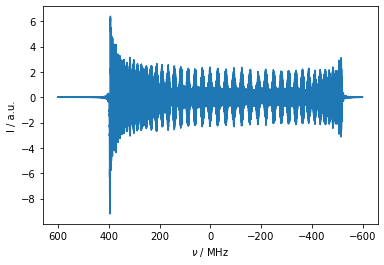

In [16]:
ex=sl.ExpSys(v0H=250,Nucs=['e-'],LF=[False],vr=100000,T_K=80,pwdavg=sl.PowderAvg('alpha0beta45')[0])
ex.set_inter('g',i=0,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6,OS=True)
L.add_relax('T1',i=0,T1=250e-6,OS=True,Thermal=True)

seq=L.Sequence()

rho=sl.Rho('ex','ep')
rho.DetProp(seq,n=12000,n_per_seq=12000)

rho.plot(FT=True,axis='MHz')

Then, we irradiate a little off the center, at -50 MHz.

### Build the System

In [82]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=[False,False,True],vr=5000,T_K=80,pwdavg=sl.PowderAvg(q=2)[3])
delta=2e6
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,0,0])
# ex.set_inter('hyperfine',i0=0,i1=2,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,np.pi/2*.8,0])
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,0,0])
ex.set_inter('g',i=0,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,np.pi/2*.8,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6,OS=True)
L.add_relax('T2',i=1,T2=5e-6,OS=True)
L.add_relax('T1',i=0,T1=250e-5,OS=True,Thermal=True)
L.add_relax('T1',i=1,T1=250e-5,OS=True,Thermal=True)
L.add_relax('T2',i=2,T2=5e-3,OS=True)
_=L.add_relax('T1',i=2,T1=3,OS=True,Thermal=True)

<IPython.core.display.Javascript object>


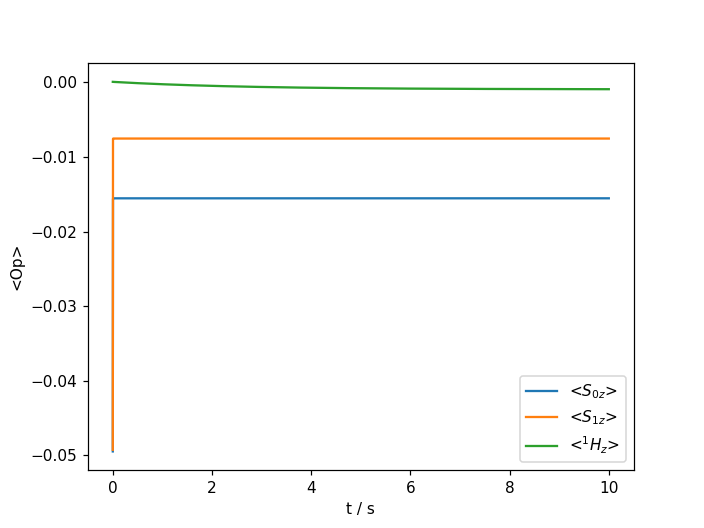

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

In [83]:
seq=L.Sequence().add_channel(1,v1=1e6,voff=-0e6)

ON=sl.Rho('Thermal',['S0z','S1z','1Hz'])
ON.DetProp(seq**10,n=5000)
ON.plot(axis='s')

A significant nuclear enhancement is achieved. However, if we remove the electron saturation, the $^1$H magnetization nonetheless evolves away from thermal equilibrium, reducing its magnetization. Then, if the enhancement were determined experimentally by recording an "On-" signal and an "Off-" signal, the apparent enhancement (On/Off) would be higher than the real enhancement. We calculate the Off-signal below, and calculate the real and apparent enhancements.

<IPython.core.display.Javascript object>


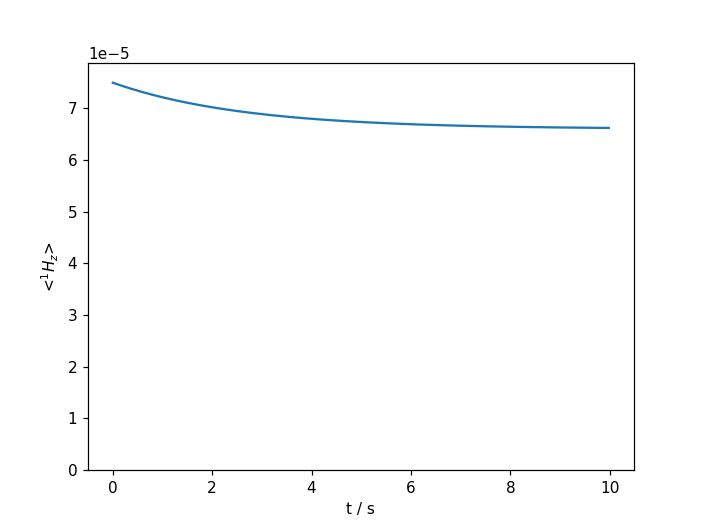

In [84]:
seq=L.Sequence()

OFF=sl.Rho('Thermal',['S0z','S1z','1Hz'])
OFF.DetProp(seq**100,n=500)
ax=OFF.plot(axis='s',det_num=2)
_=ax.set_ylim([0,ex.Peq[2]*1.05])

In [85]:
print(f'Apparent enhancement: {(ON.I[-1][-1]/OFF.I[-1][-1]).real:.0f}')
print(f'Real enhancement: {(ON.I[-1][-1]/ex.Peq[-1]).real:.0f}')

Apparent enhancement: -14
Real enhancement: -12


State-space reduction: 64->24
Prop: 100 steps per every 1 rotor period


<IPython.core.display.Javascript object>


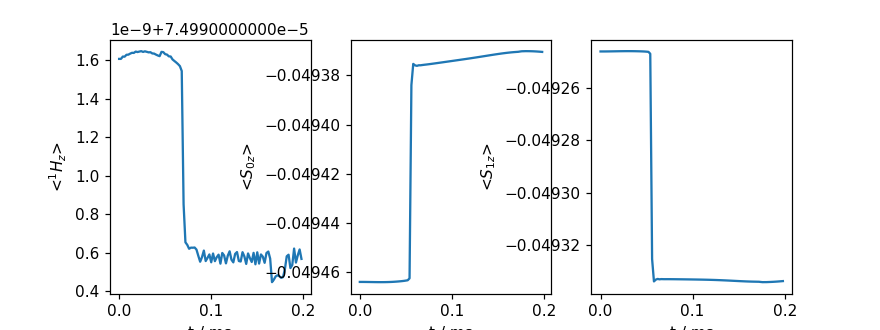

Maximum change in 1H polarization: 68 μs


<AxesSubplot:xlabel='t / ms', ylabel='<$S_{1z}$>'>

In [86]:
seq=L.Sequence().add_channel('e-',v1=0*1e6,voff=-0e6)
rho=sl.Rho('Thermal',['S0z','S1z','1Hz'])
rho.DetProp(seq,n=100,n_per_seq=100)
ax=plt.subplots(1,3,figsize=[8,3],sharex=True)[1]
rho.plot(ax=ax[0],det_num=2)

i=np.argmax(np.abs(np.diff(rho.I[2]))) #Search for the maximum difference in 1H polarization
print(f'Maximum change in 1H polarization: {rho.t_axis[i]*1e6:.0f} μs')
rho.plot(ax=ax[1],det_num=0)
# ax[1].set_ylim(rho.I[0][i].real*np.array([.99,1.01]))
# ax[1].set_xlim([rho.t_axis[i-5],rho.t_axis[i+5]])

rho.plot(ax=ax[2],det_num=1)
# ax[2].set_ylim(rho.I[1][i].real*np.array([.99,1.01]))

In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


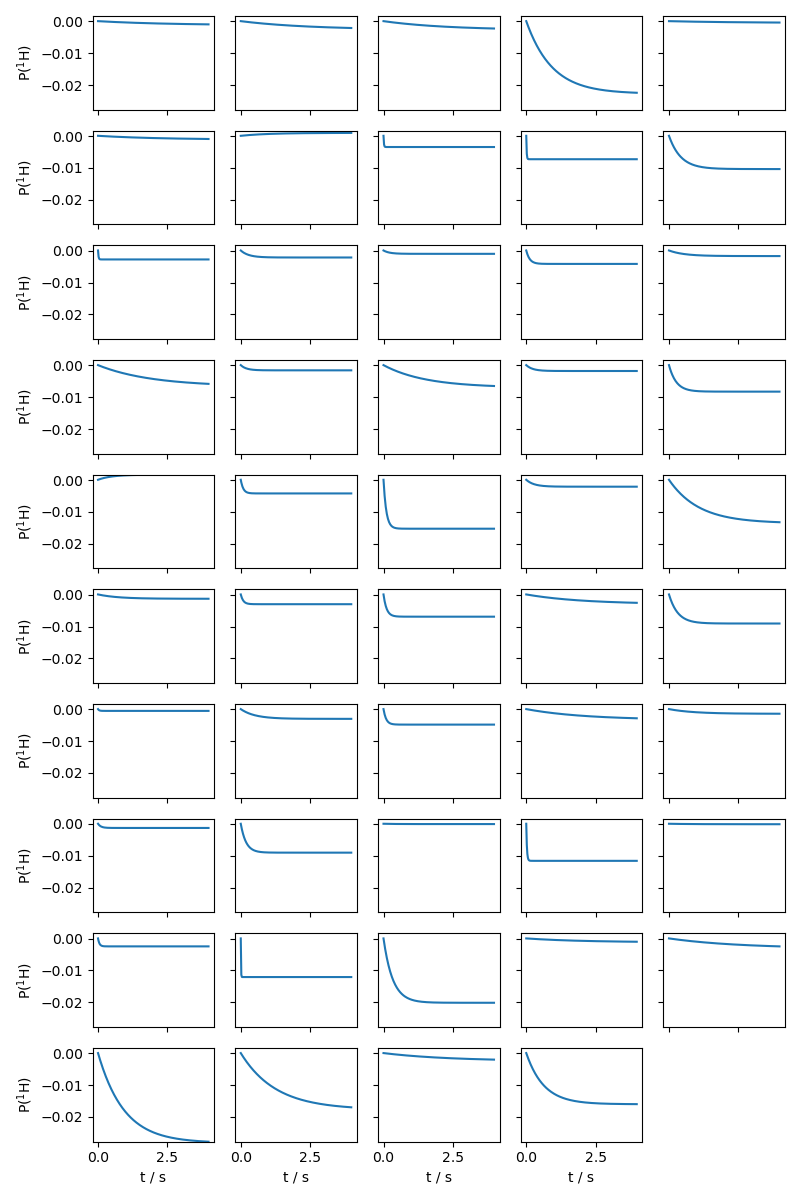

In [14]:
fig=plt.figure()
ax=[fig.add_subplot(10,5,k+1) for k in range(len(ON.Ipwd))]
for k,a in enumerate(ax):
    a.plot(ON.t_axis[::100],ON.Ipwd[k][-1][::100].real)
    a.set_ylim([ON.Ipwd[:,-1].real.min(),ON.Ipwd[:,-1].real.max()])
    if a.is_first_col():
        a.set_ylabel(r'P($^1$H)')
    else:
        a.set_yticklabels([])
    if a.is_last_row():
        a.set_xlabel('t / s')
    else:
        a.set_xticklabels([])
fig.set_size_inches([8,12])
fig.tight_layout()

<IPython.core.display.Javascript object>


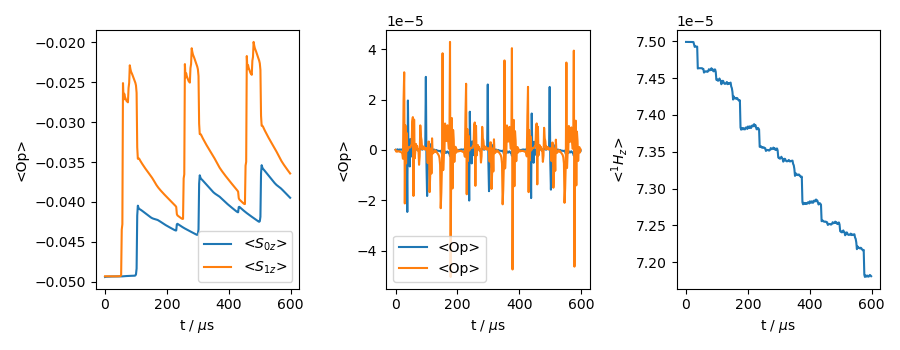

Prop: 100 steps per every 1 rotor period


In [22]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=[False,False,True],vr=5000,T_K=80,pwdavg=sl.PowderAvg(q=2)[45])
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
L.add_relax('recovery',OS=True)

seq=L.Sequence().add_channel('e-',v1=1e6,voff=-250e6)

fig,ax=plt.subplots(1,3,sharex=True)

Op=ex.Op

rho=sl.Rho('Thermal',['S0z','S1z',Op[0].p@Op[2].m+Op[0].m@Op[2].p,
                      Op[1].p@Op[2].m+Op[1].m@Op[2].p,'1Hz'])
rho.clear()
rho.DetProp(seq,n=300,n_per_seq=100)
rho.plot(axis='us',ax=ax[0],det_num=[0,1])
rho.plot(axis='us',ax=ax[1],det_num=[2,3])
rho.plot(axis='us',ax=ax[2],det_num=4)
fig.set_size_inches([9,3.5])
fig.tight_layout()

<IPython.core.display.Javascript object>


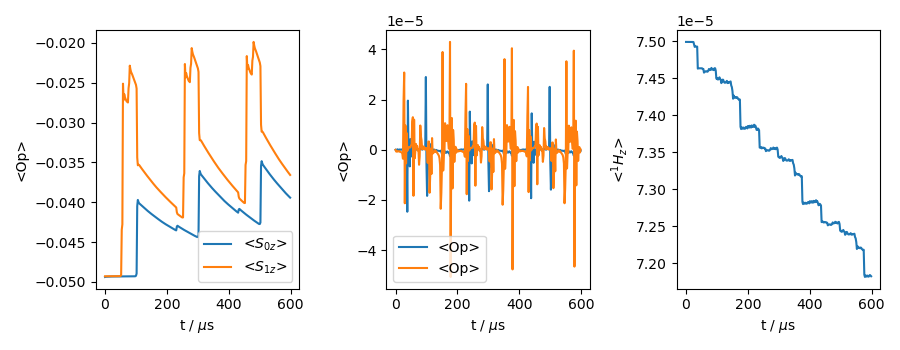

Prop: 100 steps per every 1 rotor period


In [23]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=[False,False,True],vr=5000,T_K=80,pwdavg=sl.PowderAvg(q=2)[45])
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6,OS=True)
L.add_relax('T2',i=1,T2=5e-6,OS=True)
L.add_relax('T1',i=0,T1=250e-6,OS=True,Thermal=True)
L.add_relax('T1',i=1,T1=250e-6,OS=True,Thermal=True)
L.add_relax('T2',i=2,T2=5e-3,OS=True)
L.add_relax('T1',i=2,T1=3,OS=True,Thermal=True)

seq=L.Sequence().add_channel('e-',v1=1e6,voff=-250e6)

fig,ax=plt.subplots(1,3,sharex=True)

Op=ex.Op

rho=sl.Rho('Thermal',['S0z','S1z',Op[0].p@Op[2].m+Op[0].m@Op[2].p,
                      Op[1].p@Op[2].m+Op[1].m@Op[2].p,'1Hz'])
rho.clear()
rho.DetProp(seq,n=300,n_per_seq=100)
rho.plot(axis='us',ax=ax[0],det_num=[0,1])
rho.plot(axis='us',ax=ax[1],det_num=[2,3])
rho.plot(axis='us',ax=ax[2],det_num=4)
fig.set_size_inches([9,3.5])
fig.tight_layout()

/Users/albertsmith/Documents/GitHub/SLEEPY/Liouvillian.py:432: UserWarning: Unknown relaxation type: Thermal
  warnings.warn(f'Unknown relaxation type: {Type}')


<IPython.core.display.Javascript object>


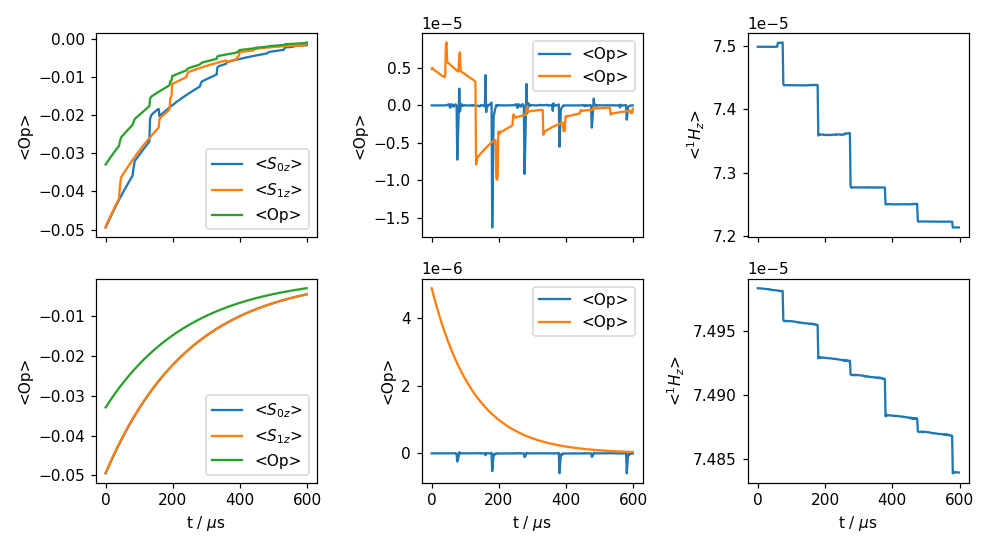

1.0000000000003983
Prop: 100 steps per every 1 rotor period
0.9999999999974907
State-space reduction: 64->24
Prop: 100 steps per every 1 rotor period


In [64]:
ex=sl.ExpSys(v0H=250,Nucs=['e-','e-','1H'],LF=[False,False,True],vr=5000,T_K=80,
             pwdavg=sl.PowderAvg(q=2)[10],rotor_angle=np.arccos(np.sqrt(1/3)))
ex.set_inter('hyperfine',i0=1,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,0,0])
ex.set_inter('hyperfine',i0=0,i1=2,Axx=-1000000,Ayy=-1000000,Azz=2000000,euler=[0,np.pi/2,0])
ex.set_inter('g',i=0,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,0,0])
ex.set_inter('g',i=1,gxx=2.0022,gyy=2.0059,gzz=2.0098,euler=[0,np.pi/2,0])
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(1.33,'e-','e-'),euler=[0,77*np.pi/180,0])

Dt=1e-3 if ex.vr==0 else None

L=ex.Liouvillian()
L.add_relax('T2',i=0,T2=5e-6)
L.add_relax('T2',i=1,T2=5e-6)
L.add_relax('T1',i=0,T1=250e-6)
L.add_relax('T1',i=1,T1=250e-6)
L.add_relax('T2',i=2,T2=5e-3)
L.add_relax('T1',i=2,T1=3)
L.add_relax('Thermal')

Op=ex.Op
rho=sl.Rho('Thermal',['S0z','S1z',Op[0].p@Op[1].m@Op[2].p+Op[0].m@Op[1].p@Op[2].p,
                      1000*Op[0].z@Op[1].z,Op[0].z+Op[1].z+Op[2].z,'1Hz'])

voff=-100e6
seq=L.Sequence(Dt).add_channel('e-',v1=1e6,voff=voff)

fig,ax=plt.subplots(2,3,sharex=True)
print(np.abs(np.linalg.eig(seq.U(Dt)[0])[0]).max())



rho.clear()
rho.DetProp(seq,n=300,n_per_seq=100)
rho.downmix()
rho.plot(axis='us',ax=ax[0,0],det_num=[0,1,4])
rho.plot(axis='us',ax=ax[0,1],det_num=[2,3])
rho.plot(axis='us',ax=ax[0,2],det_num=-1)
fig.set_size_inches([9,3.5])
fig.tight_layout()

seq=L.Sequence(Dt).add_channel('e-',v1=0*1e6,voff=voff)
print(np.abs(np.linalg.eig(seq.U(Dt)[0])[0]).max())

rho.clear()
rho.DetProp(seq,n=300,n_per_seq=100)
rho.downmix()
rho.plot(axis='us',ax=ax[1,0],det_num=[0,1,4])
rho.plot(axis='us',ax=ax[1,1],det_num=[2,3])
rho.plot(axis='us',ax=ax[1,2],det_num=-1)
fig.set_size_inches([9,5])
for a in ax[0]:a.set_xlabel('')
fig.tight_layout()